<a href="https://colab.research.google.com/github/nv-hiep/ML_end2end_projects/blob/main/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import string
import pickle

import numpy as np
import matplotlib.image as mpimg
import pandas as pd

from tqdm import tqdm
from time import time
from PIL import Image
from datetime import date


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# 2. Connect to Google Drive

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/MachineLearning/
!ls

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/MachineLearning


# 3. Paths to Data Directories

In [ ]:
PROJECT_PATH = '/content/gdrive/My Drive/Colab Notebooks/MachineLearning'
DATA_PATH    = os.path.join( PROJECT_PATH, 'data' )

# 4. Load data

In [ ]:
# Load Dataset into a dataframe
data_file = os.path.join(DATA_PATH, 'car_data.csv')
df        = pd.read_csv(data_file)

In [ ]:
df.head(4)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0


In [ ]:
# Number of rows and columns (rows, cols)
df.shape

(301, 9)

In [ ]:
# Print feature names
print(df.columns)

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')


# 5. Data Wrangling

Unique values of categorical features

In [ ]:
print("Seller_Type: ", df.Seller_Type.unique())
df.Seller_Type.value_counts()

Seller_Type:  ['Dealer' 'Individual']


Dealer        195
Individual    106
Name: Seller_Type, dtype: int64

In [ ]:
print("Transmission: ", df.Transmission.unique())
df.Transmission.value_counts()

Transmission:  ['Manual' 'Automatic']


Manual       261
Automatic     40
Name: Transmission, dtype: int64

In [ ]:
print("Fuel_Type: ", df.Fuel_Type.unique())
df.Fuel_Type.value_counts()

Fuel_Type:  ['Petrol' 'Diesel' 'CNG']


Petrol    239
Diesel     60
CNG         2
Name: Fuel_Type, dtype: int64

In [ ]:
print("Owner: ", df.Owner.unique())
df.Owner.value_counts()

Owner:  [0 1 3]


0    290
1     10
3      1
Name: Owner, dtype: int64

Check NULL values

In [ ]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [ ]:
df[['Selling_Price', 'Present_Price', 'Kms_Driven']].describe()

,Selling_Price,Present_Price,Kms_Driven
count,301.000000,301.000000,301.000000
mean,4.661296,7.628472,36947.205980
std,5.082812,8.644115,38886.883882
min,0.100000,0.320000,500.000000
25%,0.900000,1.200000,15000.000000
50%,3.600000,6.400000,32000.000000
75%,6.000000,9.900000,48767.000000
max,35.000000,92.600000,500000.000000


Current year: 2020

In [ ]:
# date.today().year
current_year = 2020
current_year

2020

Add a column: Age of cars

In [ ]:
# Age of cars
df["Years"] = current_year - df["Year"]
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Years
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,6
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,7
18,wagon r,2015,3.25,5.09,35500,CNG,Dealer,Manual,0,5
19,sx4,2010,2.65,7.98,41442,Petrol,Dealer,Manual,0,10
20,alto k10,2016,2.85,3.95,25000,Petrol,Dealer,Manual,0,4


In [ ]:
# Drop unnecessary columns
tb = df.drop(["Car_Name", "Year"], axis=1)
tb.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Years
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,6
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,7
18,3.25,5.09,35500,CNG,Dealer,Manual,0,5
19,2.65,7.98,41442,Petrol,Dealer,Manual,0,10
20,2.85,3.95,25000,Petrol,Dealer,Manual,0,4


In [ ]:
# Rearrange the columns
tb = tb[['Selling_Price', 'Present_Price', 'Years', 'Kms_Driven', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']]
tb.head()

,Selling_Price,Present_Price,Years,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,3.35,5.59,6,27000,Petrol,Dealer,Manual,0
1,4.75,9.54,7,43000,Diesel,Dealer,Manual,0
18,3.25,5.09,5,35500,CNG,Dealer,Manual,0
19,2.65,7.98,10,41442,Petrol,Dealer,Manual,0
20,2.85,3.95,4,25000,Petrol,Dealer,Manual,0


### Get dummies for categorical variables: one-hot codings

In [ ]:
tb = pd.get_dummies(tb, drop_first=True)
tb.head()

,Selling_Price,Present_Price,Years,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,6,27000,0,0,1,0,1
1,4.75,9.54,7,43000,0,1,0,0,1
18,3.25,5.09,5,35500,0,0,0,0,1
19,2.65,7.98,10,41442,0,0,1,0,1
20,2.85,3.95,4,25000,0,0,1,0,1


### The correlations of the variables

Calc. the correlations of the variables

In [ ]:
tb.corr()

,Selling_Price,Present_Price,Years,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,1.000000,0.880914,-0.222713,0.035171,-0.085787,0.561861,-0.548419,-0.549397,-0.377187
Present_Price,0.880914,1.000000,0.055301,0.204835,0.009104,0.492807,-0.483129,-0.516647,-0.354259
Years,-0.222713,0.055301,1.000000,0.523562,0.181538,-0.027490,0.023641,0.021898,0.004845
Kms_Driven,0.035171,0.204835,0.523562,1.000000,0.088133,0.184430,-0.184147,-0.112097,-0.167767
Owner,-0.085787,0.009104,0.181538,0.088133,1.000000,-0.047773,0.050302,0.118975,-0.049053
Fuel_Type_Diesel,0.561861,0.492807,-0.027490,0.184430,-0.047773,1.000000,-0.976750,-0.340316,-0.133736
Fuel_Type_Petrol,-0.548419,-0.483129,0.023641,-0.184147,0.050302,-0.976750,1.000000,0.349149,0.124571
Seller_Type_Individual,-0.549397,-0.516647,0.021898,-0.112097,0.118975,-0.340316,0.349149,1.000000,0.074043
Transmission_Manual,-0.377187,-0.354259,0.004845,-0.167767,-0.049053,-0.133736,0.124571,0.074043,1.000000


In [ ]:
# Columns of the Correlation Matrix
tb_cols = tb.corr().index
tb_cols

Index(['Selling_Price', 'Present_Price', 'Years', 'Kms_Driven', 'Owner',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Seller_Type_Individual',
       'Transmission_Manual'],
      dtype='object')

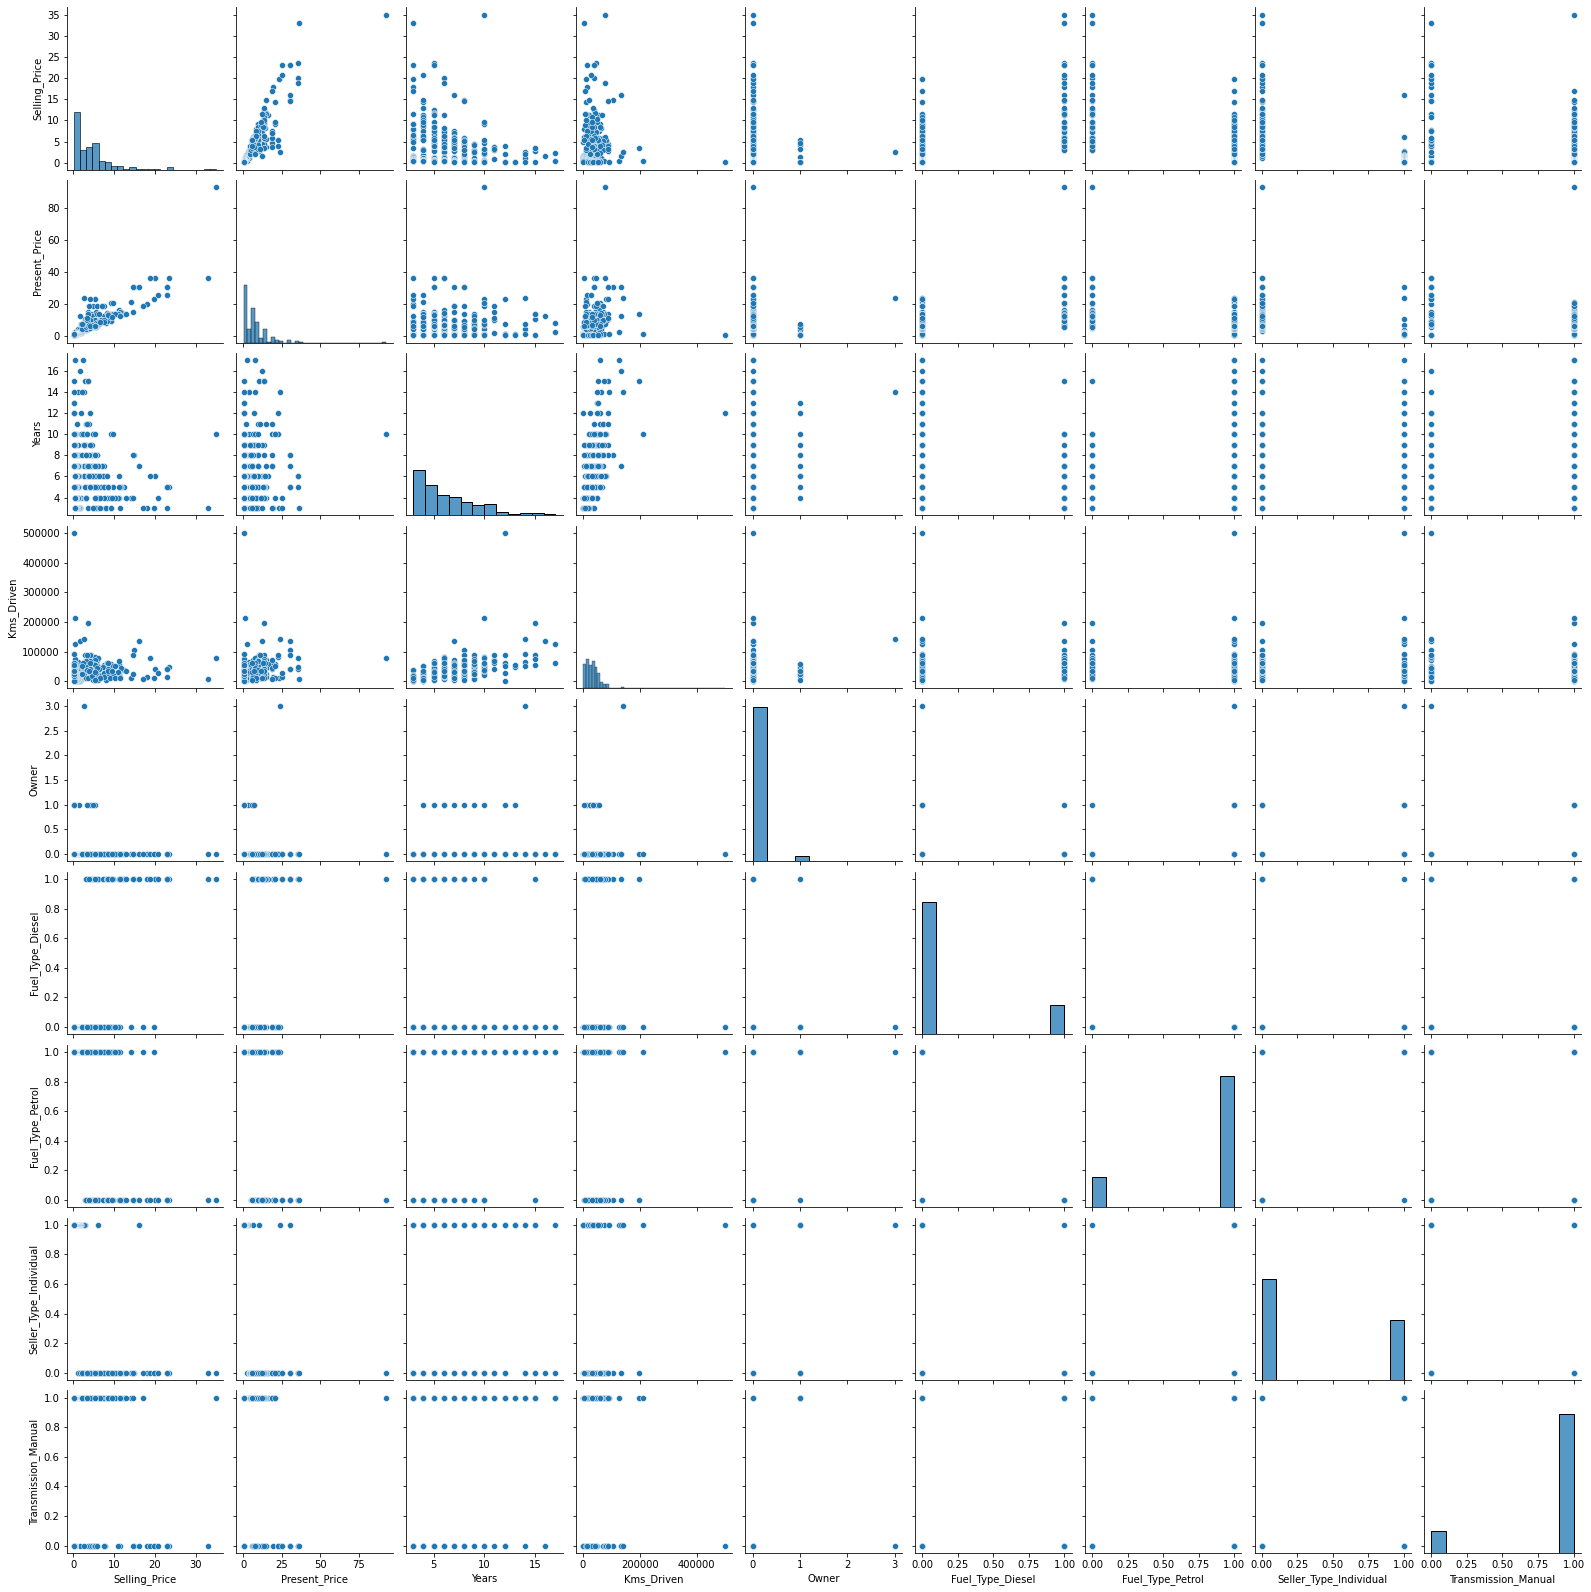

In [ ]:
# Pairplot of the Correlations
sns.pairplot(tb)

The pairplot doesn't give us much infor. We'll plot a heatmap.

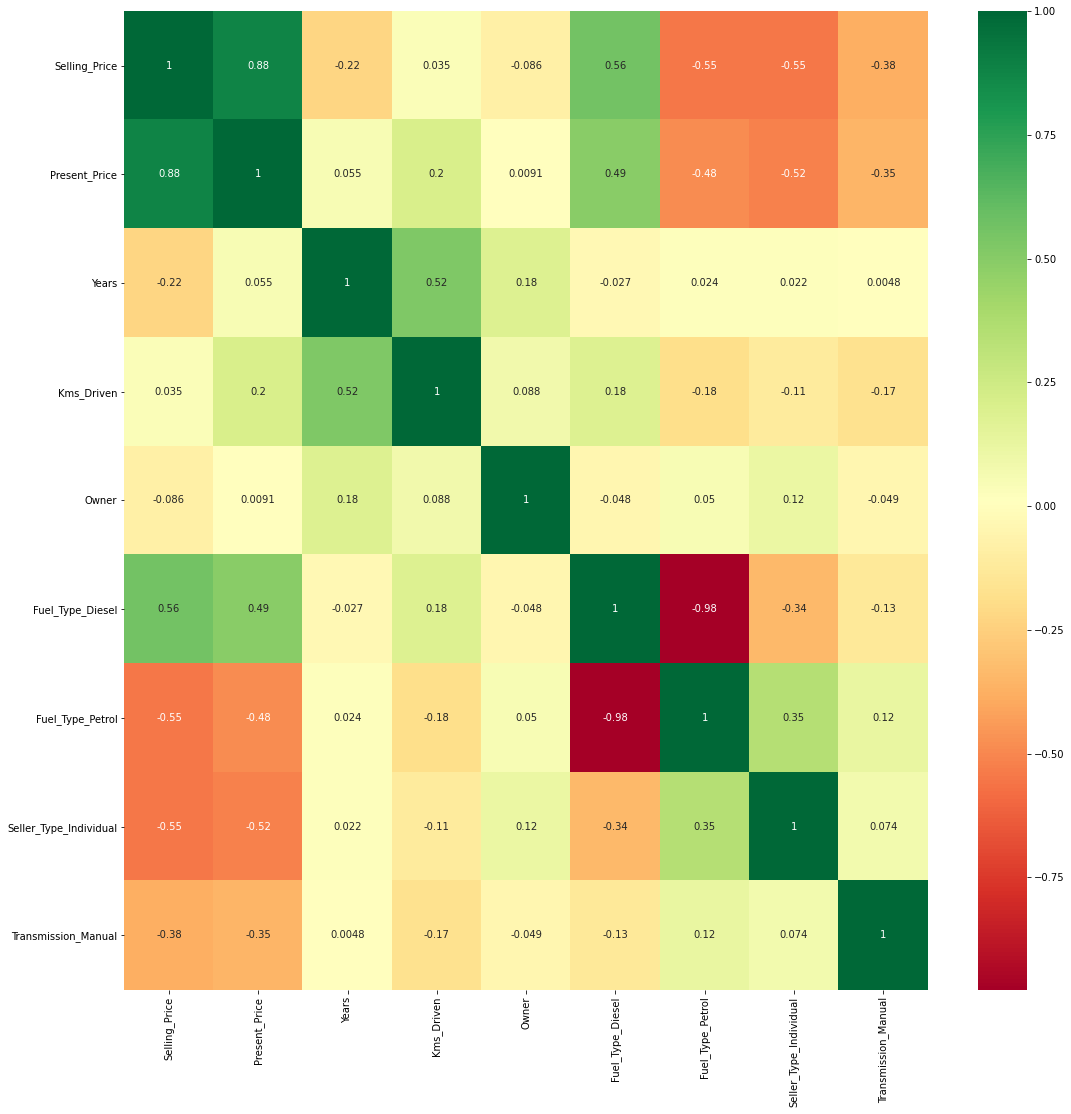

In [ ]:
plt.figure(figsize=(18,18))
sns.heatmap(tb.corr(), annot=True, cmap="RdYlGn")
plt.show()

 'Selling_Price' and 'Present_Price' are strongly positively correlated. 'Fuel_Type_Diesel' and 'Fuel_Type_Petrol' are strongly negatively correlated.

### Labels (dependent variable) and features (independent variables)

Labels and Features

In [ ]:
tb_cols

Index(['Selling_Price', 'Present_Price', 'Years', 'Kms_Driven', 'Owner',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Seller_Type_Individual',
       'Transmission_Manual'],
      dtype='object')

In [ ]:
X = tb.iloc[:, 1:]
y = tb.iloc[:, 0]

In [ ]:
X.head()

,Present_Price,Years,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5.59,6,27000,0,0,1,0,1
1,9.54,7,43000,0,1,0,0,1
18,5.09,5,35500,0,0,0,0,1
19,7.98,10,41442,0,0,1,0,1
20,3.95,4,25000,0,0,1,0,1


In [ ]:
y.head()

0     3.35
1     4.75
18    3.25
19    2.65
20    2.85
Name: Selling_Price, dtype: float64

You should drop columns with high correlation scores. With a dataframe of many columns, you should do this as following.

In [ ]:
cor_matrix = tb.corr().abs()
cor_matrix

,Selling_Price,Present_Price,Years,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,1.000000,0.880914,0.222713,0.035171,0.085787,0.561861,0.548419,0.549397,0.377187
Present_Price,0.880914,1.000000,0.055301,0.204835,0.009104,0.492807,0.483129,0.516647,0.354259
Years,0.222713,0.055301,1.000000,0.523562,0.181538,0.027490,0.023641,0.021898,0.004845
Kms_Driven,0.035171,0.204835,0.523562,1.000000,0.088133,0.184430,0.184147,0.112097,0.167767
Owner,0.085787,0.009104,0.181538,0.088133,1.000000,0.047773,0.050302,0.118975,0.049053
Fuel_Type_Diesel,0.561861,0.492807,0.027490,0.184430,0.047773,1.000000,0.976750,0.340316,0.133736
Fuel_Type_Petrol,0.548419,0.483129,0.023641,0.184147,0.050302,0.976750,1.000000,0.349149,0.124571
Seller_Type_Individual,0.549397,0.516647,0.021898,0.112097,0.118975,0.340316,0.349149,1.000000,0.074043
Transmission_Manual,0.377187,0.354259,0.004845,0.167767,0.049053,0.133736,0.124571,0.074043,1.000000


In [ ]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,Selling_Price,Present_Price,Years,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,NaN,0.880914,0.222713,0.035171,0.085787,0.561861,0.548419,0.549397,0.377187
Present_Price,NaN,NaN,0.055301,0.204835,0.009104,0.492807,0.483129,0.516647,0.354259
Years,NaN,NaN,NaN,0.523562,0.181538,0.027490,0.023641,0.021898,0.004845
Kms_Driven,NaN,NaN,NaN,NaN,0.088133,0.184430,0.184147,0.112097,0.167767
Owner,NaN,NaN,NaN,NaN,NaN,0.047773,0.050302,0.118975,0.049053
Fuel_Type_Diesel,NaN,NaN,NaN,NaN,NaN,NaN,0.976750,0.340316,0.133736
Fuel_Type_Petrol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.349149,0.124571
Seller_Type_Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.074043
Transmission_Manual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find the highly correlated variables and drop

In [ ]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop

['Fuel_Type_Petrol']

In [ ]:
tb1 = tb.drop(to_drop, axis=1)
tb1.head()

,Selling_Price,Present_Price,Years,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,6,27000,0,0,0,1
1,4.75,9.54,7,43000,0,1,0,1
18,3.25,5.09,5,35500,0,0,0,1
19,2.65,7.98,10,41442,0,0,0,1
20,2.85,3.95,4,25000,0,0,0,1


In [ ]:
X1 = tb1.iloc[:, 1:]
y1 = tb1.iloc[:, 0]

In [ ]:
X1.head()

,Present_Price,Years,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual
0,5.59,6,27000,0,0,0,1
1,9.54,7,43000,0,1,0,1
18,5.09,5,35500,0,0,0,1
19,7.98,10,41442,0,0,0,1
20,3.95,4,25000,0,0,0,1


In [ ]:
y1.head()

0     3.35
1     4.75
18    3.25
19    2.65
20    2.85
Name: Selling_Price, dtype: float64

### Feature Importance

Now, we should find the impotant features with sklearn.ensemble ExtraTreesRegressor.

In [ ]:
## Feature Importance
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
fi_model = ExtraTreesRegressor()
fi_model.fit(X1,y1)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
X1.columns

Index(['Present_Price', 'Years', 'Kms_Driven', 'Owner', 'Fuel_Type_Diesel',
       'Seller_Type_Individual', 'Transmission_Manual'],
      dtype='object')

In [ ]:
fi_model.feature_importances_

array([0.37321609, 0.07604827, 0.03799864, 0.00084457, 0.24984356,
       0.11756839, 0.14448047])

Show the Feature Importance

In [ ]:
fti = pd.Series(fi_model.feature_importances_, X1.columns)
# fti = pd.DataFrame({'feature_importances':fi_model.feature_importances_, 'columns':X1.columns})
fti.head(10)

Present_Price             0.373216
Years                     0.076048
Kms_Driven                0.037999
Owner                     0.000845
Fuel_Type_Diesel          0.249844
Seller_Type_Individual    0.117568
Transmission_Manual       0.144480
dtype: float64

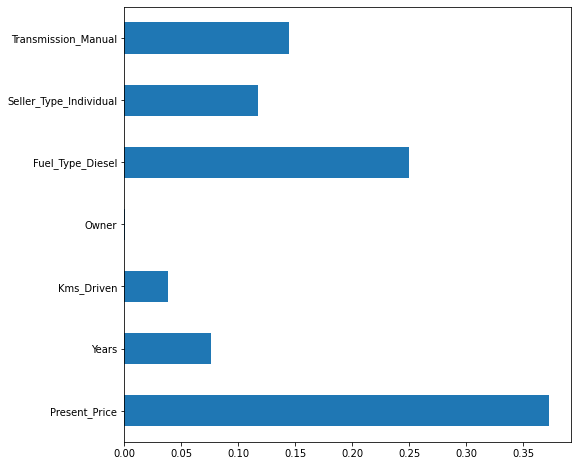

In [ ]:
plt.figure(figsize=(8,8))
# fti.sort_values('feature_importances', ascending=False)[['feature_importances','columns']].plot(kind="bar")
fti.plot(kind="barh")
plt.show()

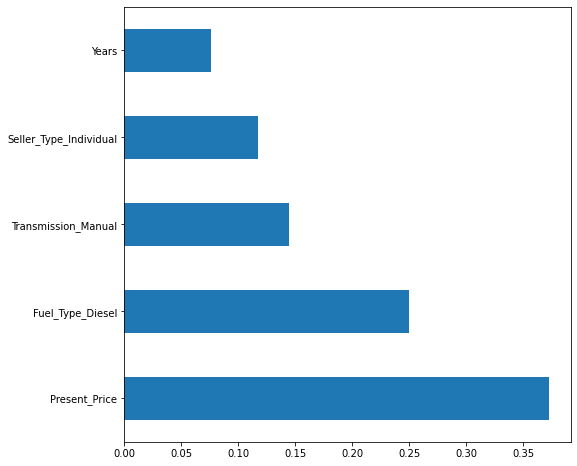

In [ ]:
# Plot 5 most important features only
plt.figure(figsize=(8,8))
fti.nlargest(5).plot(kind='barh')
plt.show()

# 6. Training and Test datasets

Training and Test datasets: 30% for the test set and 70% for the training set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=0)

# 7. Predict car price using RandomForestRegressor and RandomizedSearchCV

We don't need to scale the data, because we are going to use the RandomForest Algorithm, and it doesn't need the data to be scaled.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_model = RandomForestRegressor()

In [ ]:
# n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2,
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,
# min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False,
# n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# For fine-tuning the Hyperparameters with Randomized Search CV
# We may use the GridSearchCS here, but RandomizedSearchCV would be faster/better.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
print(max_features)

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
print(max_depth)

# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
print(min_samples_split)

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
print(min_samples_leaf)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
['auto', 'sqrt']
[5, 10, 15, 20, 25, 30]
[2, 5, 10, 15, 100]
[1, 2, 5, 10]


In [ ]:
# Random grid (key : value pairs)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

random_grid

{'max_depth': [5, 10, 15, 20, 25, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 5, 10],
 'min_samples_split': [2, 5, 10, 15, 100],
 'n_estimators': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200]}

In [ ]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random_search = RandomizedSearchCV(estimator = rf_model,
                               param_distributions = random_grid,
                               scoring='neg_mean_squared_error',
                               n_iter = 10,
                               cv = 5,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

In [ ]:
rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

The best Hyperparameters obtained from the RamdomizedSearchCV:

In [ ]:
rf_random_search.best_params_

{'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
# Best score
rf_random_search.best_score_

-4.8530111077891736

In [ ]:
rf_random_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Prediction from the best estimator with X_test set.

In [ ]:
pred = rf_random_search.predict(X_test)

Plot the difference between true label y_test and the predictions.

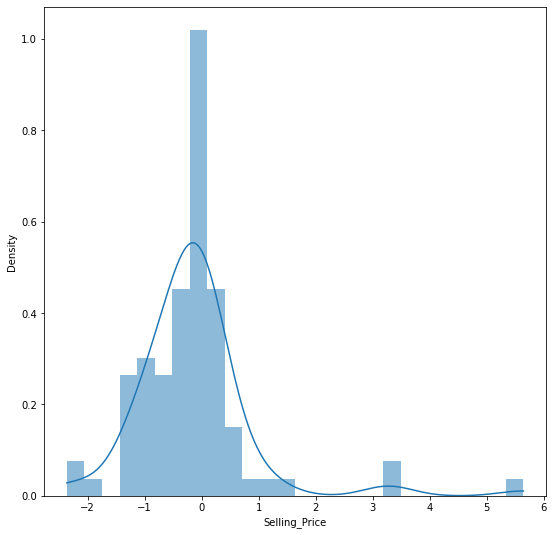

In [ ]:
plt.figure(figsize=(9,9))
sns.histplot(y_test - pred, kde=True, stat="density", linewidth=0)
plt.show()

The difference is close to 0. The model has done a pretty good job.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


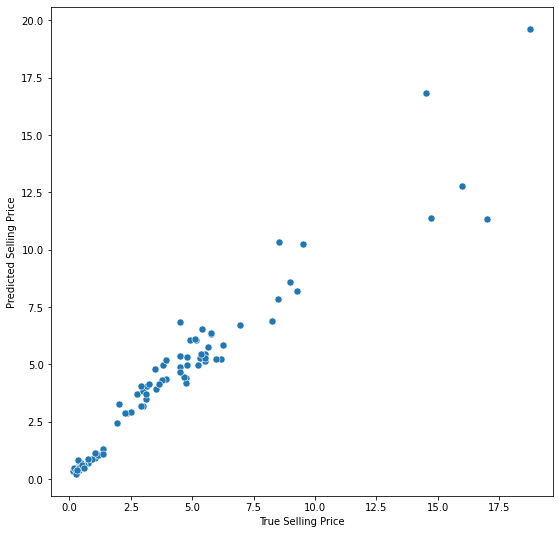

In [ ]:
plt.figure(figsize=(9,9))
sns.scatterplot(y_test, pred, s=50)
plt.xlabel("True Selling Price")
plt.ylabel("Predicted Selling Price")
plt.show()

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.6295515116279061
MSE: 1.105534270026743
RMSE: 1.0514438977076919


Save the model

In [ ]:
# open a file
xfile = open( os.path.join(DATA_PATH, 'RFRegressor_Model.pkl'), 'wb')

# dump to file
pickle.dump(rf_random_search, xfile)

In [ ]:
# Display all dependencies and their versions
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.6
cftime==1.5.0
chardet==3.0.4
charset-normalizer==2.0.4
clang==5.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed=